
# Exploring attitudes toward Yucca Mountain with Twitter

## Motivation
How countries manage nuclear waste is relevant to long-term health and safety concerns as well as the viability of continued nuclear energy production. In 2012, the Blue Ribbon Commission on America’s Nuclear Future commissioned by President Obama recommended a “consent-based” approach to deciding where to put waste management facilities. Despite this recommendation, a bill currently working its way through Congress would make Nevada’s Yucca Mountain the main repository for U.S. nuclear waste, a plan that the state of Nevada has vociferously opposed for decades. 

## Proposed project
I propose to perform Twitter sentiment analysis using Python to explore changes in how attitudes toward Yucca Mountain have (or have not) changed over time and the extent to which those attitudes relate to other factors such as geographic location and partisan affiliation. 

## Related previous work

### Twitter sentiment analyses and data on nuclear power
Essentially all of these efforts were published prior to the election of Donald Trump and focus on the (mostly negative) changes in public sentiment toward nuclear power after the 2011 accident at Fukushima rather than nuclear waste management in general or Yucca Mountain specifically. 

* [2013 US Department of Energy report](https://www.energy.gov/sites/prod/files/Public%20Preferences%20Related%20to%20Consent%20Based%20Siting%2002-01-13.pdf)
* [Kim et al. 2014](http://onlinepresent.org/proceedings/vol51_2014/51.pdf)
* [Su et al. 2016](http://www.tandfonline.com/doi/abs/10.1080/1369118X.2016.1182197?journalCode=rics20) 
* [Li et al. 2016](https://www.researchgate.net/publication/312936615_Tweeting_disaster_An_analysis_of_online_discourse_about_nuclear_power_in_the_wake_of_the_Fukushima_Daiichi_nuclear_accident)
* [data.world's CrowdFlower has a twitter dataset on nuclear energy](https://data.world/crowdflower/emotions-about-nuclear-energy)

### Surveys
There's more, but most of it is older. Right now I expect the 2016 Pew data will be my main point of comparison.

* [Regular surveys by pro-nuclear energy group](https://www.nei.org/Knowledge-Center/Public-Opinion)
* [2016 Pew Research Center survey on various energy sources](http://www.pewinternet.org/2016/10/04/public-opinion-on-renewables-and-other-energy-sources/)
* [Short review of socioeconomic work related to Yucca Mt. as of 1994](http://www.pnas.org/content/91/23/10786.full.pdf)
* [Reference to a 2007 MIT survey on Yucca Mt](http://www.nevadaappeal.com/news/local/survey-shows-most-americans-oppose-yucca-mountain/)

## Gathering Twitter data
As a start, I used Twitter's REST API to download a total of 600 tweets: 300 for the query 'nuclear power' and 300 for 'Yucca Mountain'. That code is not included on GitHub because it contains my authententication data. Going forward, I'll need to work around Twitter's rate limits to gather more data and possibly switch to the streaming API. 

## Importing tweets stored in json format

In [1]:
import json

def get_saved_data(list_of_json_files):
    all_tweets = []
    for file in list_of_json_files:
        with open(file) as datafile:
            newtweets = json.load(datafile)
            all_tweets = all_tweets + newtweets
    
    unique_tweets = []
    list_of_ids = []
    for tweet in all_tweets:
        if tweet['id'] not in list_of_ids:
            list_of_ids.append(tweet['id'])
            unique_tweets.append(tweet)

    return unique_tweets

# tweets related to nuclear power and yucca mountain in this repo
powerfiles = ['powerdata.txt', 'powerdata2.txt', 'powerdata3.txt']
yuccafiles = ['yuccadata1.txt', 'yuccadata2.txt', 'yuccadata3.txt']

powertweets = get_saved_data(powerfiles)
yuccatweets = get_saved_data(yuccafiles)

## First-pass clean up and sentiment analysis with regex and Textblob
I use the cleaning and simple unsupervised sentiment analysis strategy from [this website](http://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/).

In [2]:
import re
from textblob import TextBlob

for tweet in powertweets + yuccatweets:
    tweet['text'] = re.sub("(@[A-Za-z0-9]+)| \
                    ([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet['text'])
    analysis = TextBlob(tweet['text'])
    if analysis.sentiment.polarity > 0:
        tweet['sentiment'] = 'positive'
    elif analysis.sentiment.polarity == 0:
        tweet['sentiment'] = 'neutral'
    else:
        tweet['sentiment'] = 'negative'

## Tweet location

### Where possible, determine state information for users tweeting about nuclear power

In [3]:
import us

states = [state.name for state in us.states.STATES]
abbrevs = [state.abbr for state in us.states.STATES]
states_and_abbrevs = states + abbrevs


def determine_state(tweet):
    """ Assign tweet['state'] where possible """

    # exclude user tweets with no location information
    if not tweet['user']['location']:
        tweet['state'] = None
        
    user_location = tweet['user']['location']

    # 'Japan' gets confused with PA and
    # 'Kingdom of God' gets confused with IN
    places_to_exclude = ['JAPAN', 'KINGDOM']
    for not_really_a_state in places_to_exclude:
        if not_really_a_state in user_location:
            is_a_state = False
            break
        else:
            is_a_state = True

    if is_a_state is True:
        for place in states_and_abbrevs:
            if place in user_location:
                if place in abbrevs:
                    tweet['state'] = us.states.lookup(place).name
                else:
                    tweet['state'] = place
                break
                
for tweet in powertweets:
    determine_state(tweet)

### Plot nuclear power tweets by state

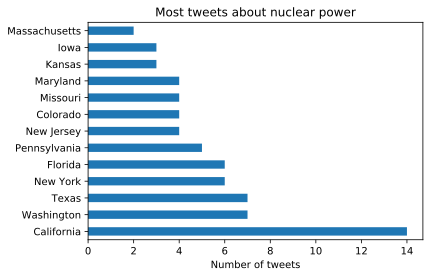

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=["svg"]

powerdata = pd.DataFrame(powertweets)
top_states = powerdata.state.value_counts()
top_states[:13].plot(kind='barh')
plt.title('Most tweets about nuclear power')
plt.xlabel('Number of tweets');

### Compare the same state location analysis for tweets about Yucca Mountain

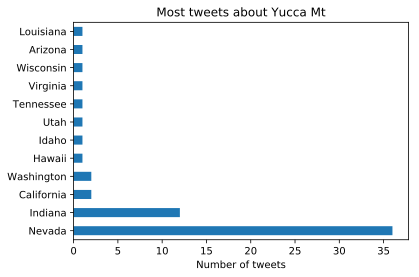

In [5]:
for tweet in yuccatweets:
    determine_state(tweet)
    
yuccadata = pd.DataFrame(yuccatweets)
top_states = yuccadata.state.value_counts()
top_states[:13].plot(kind='barh')
plt.title('Most tweets about Yucca Mt')
plt.xlabel('Number of tweets');

The vast majority of the concern about Yucca Mt is coming from Nevada, which is not surprising because Yucca Mt. is in Nevada. 

But why does Indiana care so much? I would understand if Illinois were second, because, as mentioned in [this article](https://www.theatlantic.com/science/archive/2017/04/nuclear-waste-yucca-mountain-hearing-states/524418/), Illinois has the most nuclear waste, and Representative John Shimkus (R) is the sponsor the bill that would open Yucca Mt for taking in nuclear waste, but Illinois isn't showing up. Mysterious. Maybe my state classification was wrong?

### Who is tweeting about Yucca Mt. from Indiana?

In [6]:
for tweet in yuccatweets:
    try:
        if tweet['state'] == 'Indiana':
            print(tweet['user']['name'], 'are tweeting from', tweet['user']['location'])
    except KeyError:
        pass

American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis
American Socialists are tweeting from Indianapolis


So it's all just this one person or group. I'm going to have to think about filtering by unique users.

## How do twitter users feel about Yucca Mt?

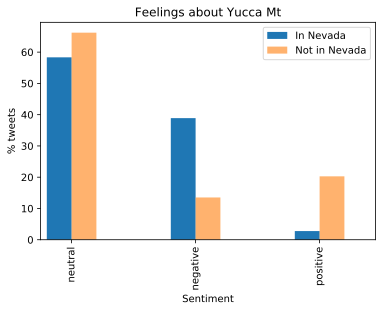

In [7]:
nevadatweets = yuccadata[yuccadata.state == 'Nevada']
notnevadatweets = yuccadata[yuccadata.state != 'Nevada']

nevadafeelings = 100. * nevadatweets.sentiment.value_counts() / len(nevadatweets)
notnevadafeelings = 100 * notnevadatweets.sentiment.value_counts() / len(notnevadatweets)

# make sure the order is the same for both groups
nevadafeelings = nevadafeelings.reindex(['neutral', 'negative', 'positive'])
notnevadafeelings = notnevadafeelings.reindex(['neutral', 'negative', 'positive'])

fig = plt.figure()
ax = fig.add_subplot(111) 
width = 0.2

nevadafeelings.plot(kind='bar', ax=ax, position=1, width=width, label='In Nevada', \
                    legend=True)
notnevadafeelings.plot(kind='bar', ax=ax, position=0, color='C1', width=width, \
                       label='Not in Nevada', legend=True, alpha=0.6)

plt.title('Feelings about Yucca Mt')
plt.ylabel('% tweets')
plt.xlabel('Sentiment');

##  Who is this Nevada resident who supports Yucca Mt?

In [9]:
for tweet in yuccatweets:
    try:
        if tweet['state'] == 'Nevada':
            if tweet['sentiment'] == 'positive':
                print()
                print(tweet['user']['name'])
                print(tweet['text'])
                print()
                print(tweet['user']['screen_name'])
                print(tweet['id'])
    except KeyError:
        pass



Tiffany Watson
    He wants thanks? Wow, I’m sure I’ll be in praise mode once Yucca mountain gets all…  

MissTW1985
924349302582870016


I'm not sure why the text is getting cut off here, but the screen name and tweet id let us go find [this tweet](https://twitter.com/MissTW1985/status/924349302582870016), which, it turns out, includes #joke, and so is probably not actually positive.

Next up will be trying to tease out partisan affiliations and their relationship to support or opposition to nuclear energy and/or Yucca Mountain.